In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import Functions
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib

 - The original transaction values, including negative values for selling, are first interpreted and encoded into distinct integer states based on your simulation logic.
 - The bounds and norm then use these encoded states to map each cell in your grid to the correct color.
 - Thus, the color mapping does not directly consider whether the original transaction value was positive or negative. It's the encoded state (which reflects whether a trader is buying, selling, or holding) that determines the color.

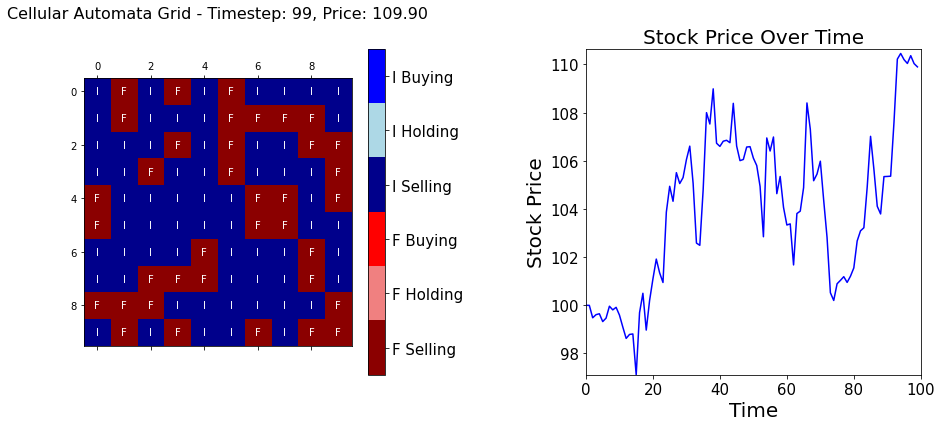

In [4]:
# Define the Level 3 simulation function
def Level_3_simulation(trader_grid, initial_price, fundamental_value, time, L, sensitivity_constant, constant_trading, news_relevance, stock_favorability, period_length):
    # Initialize price list for market
    price_list = [initial_price]
    price_fluctuation = Functions.price_fluctuations(period_length, price_list)
    price_fluctuation_list = [price_fluctuation]
    trades = Functions.trading_activity_function(constant_trading, price_fluctuation, stock_favorability)
    trades_list = [trades]
    
    news_impact = []  # List to store the news impact at each timestep

    # Initialize transaction quantities. Note that this implies at t=0 we initialize with imitators not trading and fundamentalists trading at the updated price values
    transaction_quantities = Functions.next_state_Level_3(trader_grid, np.zeros((L, L)), price_list, fundamental_value, news_relevance, L, trades)
    transactions = [transaction_quantities]
    for t in range(time):
        price_fluctuation = Functions.price_fluctuations(period_length, price_list)
        price_fluctuation_list.append(price_fluctuation)
        trades = Functions.trading_activity_function(constant_trading, price_fluctuation, stock_favorability)
        trades_list.append(trades)
        
        # Get the news impact for the current timestep
        current_news_impact = Functions.news_influence(news_relevance)
        news_impact.append(current_news_impact)

        
        transaction_quantities = Functions.next_state_Level_3(trader_grid, transactions[-1], price_list, fundamental_value, news_relevance, L, trades)
        transactions.append(transaction_quantities)
        trans_quantity = Functions.calculation_transaction_quantity(transaction_quantities, L)
        price_list.append(Functions.price_function(price_list[-1], sensitivity_constant, L, trans_quantity))
    
    return np.array(transactions), np.array(price_list), np.array(news_impact), np.array(price_fluctuation_list), np.array(trades_list)


def process_transactions(transactions, trader_grid, price_list, fundamental_value, L):
    processed = np.zeros_like(transactions, dtype=int)
    
    for t in range(transactions.shape[0]):
        for i in range(L):
            for j in range(L):
                trader_type = 1 if trader_grid[i, j] == 1 else 4  # 1 for Fundamentalist, 4 for Imitator
                current_price = price_list[t]
                action = 1  # Default action is holding

                if trader_type == 1:  # Fundamentalist
                    if current_price < fundamental_value:  # Buy when price is below fundamental value
                        action = 2  # Buying
                    elif current_price > fundamental_value:  # Sell when price is above fundamental value
                        action = 0  # Selling

                else:  # Imitator
                    neighborhood = transactions[t, max(0, i-1):min(L, i+2), max(0, j-1):min(L, j+2)]
                    avg_action = np.mean(neighborhood)
                    if avg_action > threshold:  # Define a threshold for buying
                        action = 2  # Buying
                    elif avg_action < -threshold:  # Define a threshold for selling
                        action = 0  # Selling
                    else:
                        action = 1  # Holding


                processed[t, i, j] = trader_type + action

    return processed


# Constants for the simulation
L = 10
fundamental_value = 100
initial_price = 100
time_steps = 100
sensitivity_constant = 0.8
constant_trading = 20
news_relevance = [0.2, 0.7]
stock_favorability = 0.01
period_length = 10
threshold = 0.0001

# Initialize the trader grid
trader_grid = Functions.grid_stock_market(L, 0.3)

# Run the simulation
transactions, price_list, news_impact, _, _ = Level_3_simulation(
    trader_grid, initial_price, fundamental_value, time_steps, L, 
    sensitivity_constant, constant_trading, news_relevance, 
    stock_favorability, period_length
)


# Process the transactions
processed_transactions = process_transactions(transactions, trader_grid, price_list, fundamental_value, L)

# Custom color map for different states
colors = ['darkred', 'lightcoral', 'red',  # Fundamentalist: selling, holding, buying
          'darkblue', 'lightblue', 'blue']  # Imitator: selling, holding, buying
cmap = ListedColormap(colors)
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]  # One more than the number of colors
norm = BoundaryNorm(bounds, cmap.N)


# Initialize the figure and subplots for the animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1]})

# Set up the CA grid subplot
mat = ax1.matshow(processed_transactions[0], cmap=cmap, norm=norm)
ax1.set_title('Cellular Automata Grid', fontsize=20)

# Add text annotations
texts = [[ax1.text(j, i, 'F' if trader_grid[i, j] == 1 else 'I', ha='center', va='center', color='white', fontsize=10) 
          for j in range(L)] for i in range(L)]

# Set up the price plot subplot
price_line, = ax2.plot([], [], color='blue')
ax2.set_xlim(0, time_steps)
ax2.set_ylim(min(price_list), max(price_list))
ax2.set_title('Stock Price Over Time', fontsize=20)
ax2.set_xlabel('Time', fontsize=20)
ax2.set_ylabel('Stock Price', fontsize=20)
ax2.tick_params(labelsize=15)

# Initialize function for the animation
def init():
    price_line.set_data([], [])
    return [price_line, mat] + [val for sublist in texts for val in sublist]

# Update function for the animation
def update(frame):
    grid = processed_transactions[frame % time_steps]
    mat.set_data(grid)

    # Update text annotations
    for i in range(L):
        for j in range(L):
            texts[i][j].set_text('F' if trader_grid[i, j] == 1 else 'I')

    # Update the price plot
    price_line.set_data(range(frame + 1), price_list[:frame + 1])

    # Update the title of the CA grid subplot with current timestep and price
    current_price = price_list[frame]
    ax1.set_title(f'Cellular Automata Grid - Timestep: {frame}, Price: {current_price:.2f}', fontsize=16, y=1.2)

    return [price_line, mat] + [val for sublist in texts for val in sublist]

# Create the animation
ani = FuncAnimation(fig, update, frames=time_steps, init_func=init, blit=False, repeat=False)

# Add a colorbar with a legend
colorbar = plt.colorbar(mat, ax=ax1, cmap=cmap, norm=norm, boundaries=bounds, ticks=[1, 2, 3, 4, 5, 6])
colorbar.ax.set_yticklabels(['F Selling', 'F Holding', 'F Buying', 'I Selling', 'I Holding', 'I Buying'], fontsize=15)

# Adjust layout to prevent overlap and ensure adequate spacing
fig.subplots_adjust(wspace=0.5, hspace=0.5) # Adjust the width spacing between subplots

# Save the animation
ani.save('stock_market_simulation_level3_dynamic_spacing.mp4', writer='ffmpeg')

plt.show()

In [3]:
def calculate_percentages(trader_grid):
    total_cells = trader_grid.size
    num_fundamentalists = np.sum(trader_grid == 1)
    num_imitators = total_cells - num_fundamentalists
    perc_fundamentalists = (num_fundamentalists / total_cells) * 100
    perc_imitators = (num_imitators / total_cells) * 100
    return perc_fundamentalists, perc_imitators

# Assuming 'trader_grid' is your grid after initialization
fundamentalist_percentage, imitator_percentage = calculate_percentages(trader_grid)
print(f"Percentage of Fundamentalists: {fundamentalist_percentage}%")
print(f"Percentage of Imitators: {imitator_percentage}%")

Percentage of Fundamentalists: 34.0%
Percentage of Imitators: 66.0%
